In [5]:
!pip install git+https://github.com/innat/transformers -U -q > /dev/null
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor

from kaggle_datasets import KaggleDatasets

import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
from zipfile import ZipFile
from PIL import Image
import requests

from mpl_toolkits import axes_grid1

from tensorflow.keras.utils import plot_model

import os

import tensorflow as tf

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
class config:
    VERSION = 60

    SEED = 42
    RESUME = True
    RESUME_EPOCH = 0
    RESUME_WEIGHT = "../input/guie-tensorflow-clip-largex336/clip-vit-large-patch14_336pix-emb64_loss.h5"

    model_type = "clip-vit-large-patch14"
    EFF_SIZE = 0
    EFF2_TYPE = ""

    IMAGE_SIZE = 336
    BATCH_SIZE_INFER = 16 * strategy.num_replicas_in_sync
    BATCH_SIZE_TRAIN = 100 * strategy.num_replicas_in_sync
    N_CLASSES = 92004
    EMB_DIM = 64
    EPOCHS = 200
    LR = 0.001

    save_dir = "./"

    TRAIN = False
    DEBUG = False
    
    TTA = 1


# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
seed_everything(config.SEED)

MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_SIZE}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF2_TYPE}'
elif "swin" in config.model_type:
    MODEL_NAME = config.model_type
elif "conv" in config.model_type:
    MODEL_NAME = config.model_type
else:
    MODEL_NAME = config.model_type

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

clip-vit-large-patch14


# Model

## Distance Margin Layer
This notebook uses distance margin layer instead of the ArcFace Layer.  
  
With ArcFace, the embedding vectors are distributed over the surface of an N-dimensional sphere.   
This is because ArcFaceLayer outputs the inner product of its own weight matrix and embedding vector to the next Softmax layer.   
Although this embedding vector is easy to work with, it is not a very efficient use of the embedding vector space.  

So I introduce a distance margin layer.   
This outputs the inverse squared Euclidean distance in the next Softmax layer, not the inner product.  
![DistanceMarginLayer](https://github.com/motono0223/kaggle_public/blob/main/2022_guie/GUIE_DistanceLayer.png?raw=true)

In [4]:
class DistanceMarginLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes, s=30, m=0.10, easy_margin=False,
                 ls_eps=0.0, sgm=1.0, **kwargs):

        super(DistanceMarginLayer, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.sgm = sgm

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(DistanceMarginLayer, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        
        W2 = self.W 

        X2 = tf.tile(tf.expand_dims(X, 2), [1, 1, self.W.shape[1] ])  # X.shape=[Batch, EmbDim], X2.shape=[Batch, EmbDim, NumClass]

        # distance on the N-Dimentional coordinate
        dx = tf.math.sqrt( tf.reduce_sum( tf.math.pow( X2 - W2, 2 ), axis=1) ) # dx.shape=[Batch, NumClass]

        dx = tf.clip_by_value( dx    , 0.00001, 50.0)
        output1 = self.s / tf.math.pow( dx, 2 )
        output2 = self.s / tf.math.pow( dx, 2 ) + self.m

        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=dx.dtype
        )

        output = (one_hot * output1) + ((1.0 - one_hot) * output2)

        return output

In [5]:
class ArcMarginProduct_subcenter(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0,k=3, **kwargs):

        super(ArcMarginProduct_subcenter, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.k = k
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct_subcenter, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), int(self.n_classes)*self.k),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        # print(X.shape)
        
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        # print(cosine.shape)
        cosine =tf.reshape(cosine ,[-1,self.n_classes,self.k])
        # print(cosine.shape)
        cosine = tf.reduce_max(cosine,axis=2)
        # print(cosine.shape)
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [6]:
def get_scale_layer(rescale_mode = "tf"):
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2

    if isinstance(rescale_mode, (list, tuple)):  # Specific mean and std
        mean, std = rescale_mode
    elif rescale_mode == "torch":
        mean = np.array([0.48145466, 0.4578275, 0.40821073]) * 255.0
        std = np.array([0.26862954, 0.26130258, 0.27577711]) * 255.0
    elif rescale_mode == "tf":  # [0, 255] -> [-1, 1]
        mean, std = 127.5, 127.5
    elif rescale_mode == "tf128":  # [0, 255] -> [-1, 1]
        mean, std = 128.0, 128.0
    elif rescale_mode == "raw01":
        mean, std = 0, 255.0  # [0, 255] -> [0, 1]
    else:
        mean, std = 0, 1  # raw inputs [0, 255]        
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    
    return scaling_layer

In [7]:
def get_clip_model():
    inp = tf.keras.layers.Input(shape = [3, config.IMAGE_SIZE, config.IMAGE_SIZE])
#    backbone = TFCLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
    backbone = TFCLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14-336")
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])

def get_embedding_model(frozen=True):
    #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize')
    layer_scaling = get_scale_layer(rescale_mode = "torch")
    layer_permute = tf.keras.layers.Permute((3,1,2))
    layer_backbone = get_clip_model()
    if frozen:
        layer_backbone.trainable = False
    #layer_gap = tf.keras.layers.GlobalAveragePooling2D()
    layer_dropout = tf.keras.layers.Dropout(0.2)
    layer_dense_before_arcface = tf.keras.layers.Dense(config.EMB_DIM)
    layer_margin = ArcMarginProduct_subcenter(
        n_classes = config.N_CLASSES, 
        s = 30, 
        m = 0.3,
        name=f'head/distancemargin', 
        dtype='float32'
        )
    layer_softmax = tf.keras.layers.Softmax(dtype='float32')
    if config.EMB_DIM != 64:
        layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(64)
    else:
        layer_adaptive_pooling = tf.keras.layers.Lambda(lambda x: x ) # no operation
        

    #------------------
    # Definition of entire model 
    image = layer_scaling(inp)
    image = layer_resize(image)
    image = layer_permute(image)
    backbone_output = layer_backbone(image)
    embed = layer_dropout(backbone_output)
    embed = layer_dense_before_arcface(embed)
    x = layer_margin([embed, label])
    output = layer_softmax(x)
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # whole architecture

    #------------------
    # Definition of embedding model (for submission)
    embed_model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(None, None, 3), dtype='uint8'),
        layer_scaling,
        layer_resize,
        layer_permute,
        layer_backbone,
        layer_dropout,
        layer_dense_before_arcface,
        layer_adaptive_pooling,
        tf.keras.layers.Lambda(lambda x: x, name='embedding_norm'), # dummy layer (the layer named with "embedding_norm" is required for submission)
    ])
    
    #------------------
    # Definition of backbone model (to obtain training data)
    backbone_model = tf.keras.models.Model(inputs = [inp, label], outputs = [backbone_output, label])  

    #------------------
    # Definition of projection Model (to train projection layers)
    inp_proj = tf.keras.layers.Input(shape = [backbone_output.shape[-1]], name = 'inp_proj')
    x = layer_dropout(inp_proj)
    x = layer_dense_before_arcface(x)
    x = layer_margin([x, label])
    output = layer_softmax(x)
    projection_model = tf.keras.models.Model(inputs = [inp_proj, label], outputs = [output])

    # Note: These 4 models share the same weights each other.
    return model, embed_model, backbone_model, projection_model

In [8]:
with strategy.scope():
    model, emb_model, backbone_model, projection_model = get_embedding_model()

    opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
    projection_model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    if config.RESUME:
        print(f"load {config.RESUME_WEIGHT}")
        model.load_weights( config.RESUME_WEIGHT )

Downloading:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

2022-10-07 14:32:46.963397: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-07 14:32:46.967355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-07 14:32:47.032469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 14:32:47.033153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-10-07 14:32:47.033207: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-07 14:32:47.062463: I tensorflow/stream_executor/platform/def

load ../input/guie-tensorflow-clip-largex336/clip-vit-large-patch14_336pix-emb64_loss.h5


// model to save/load weights via hdf5 file.


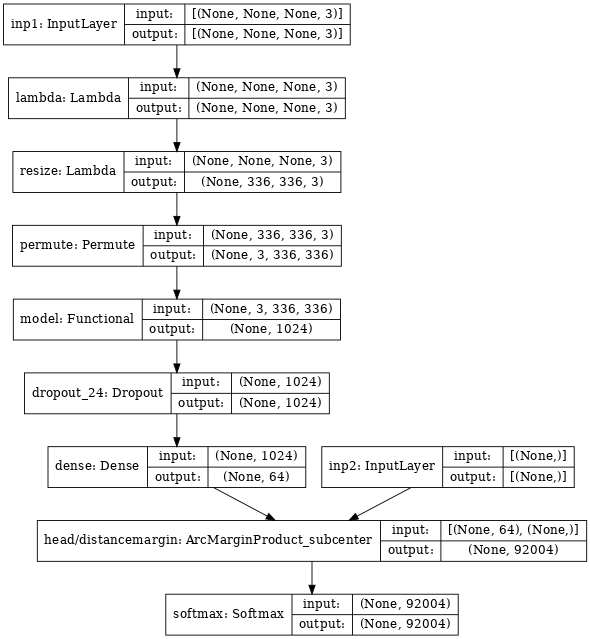

In [9]:
print( f"// model to save/load weights via hdf5 file." )
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

// emb_model for submission


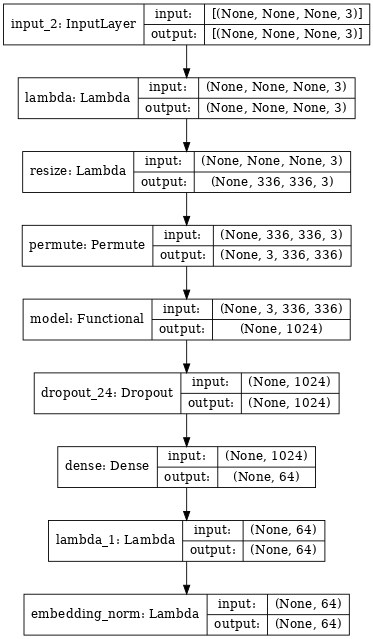

In [10]:
print( f"// emb_model for submission" )
plot_model(emb_model, show_shapes=True, show_layer_names=True, dpi=64)

// backbone_model to get training data


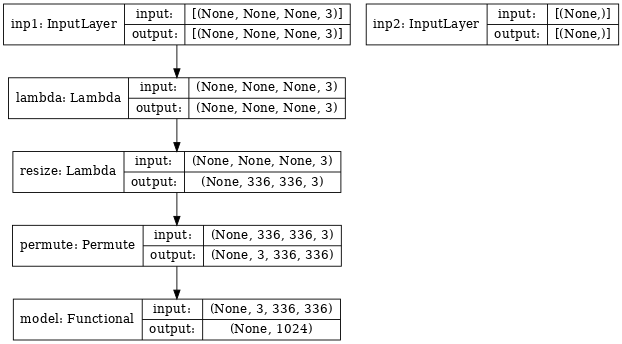

In [11]:
print( f"// backbone_model to get training data" )
plot_model(backbone_model, show_shapes=True, show_layer_names=True, dpi=64)

// projection_model to train weights


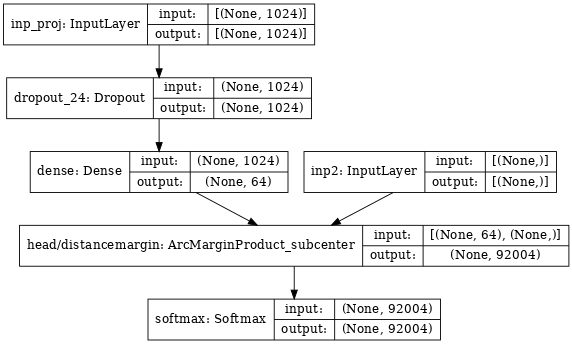

In [12]:
print( f"// projection_model to train weights" )
plot_model(projection_model, show_shapes=True, show_layer_names=True, dpi=64)

# Submission

In [13]:
save_locally = tf.saved_model.SaveOptions(
    experimental_io_device='/job:localhost'
)
emb_model.save('./embedding_norm_model', options=save_locally)

from zipfile import ZipFile

with ZipFile('submission.zip','w') as zip:           
    zip.write(
        './embedding_norm_model/saved_model.pb', 
        arcname='saved_model.pb'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.data-00000-of-00001', 
        arcname='variables/variables.data-00000-of-00001'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.index', 
        arcname='variables/variables.index'
    )

2022-10-07 14:33:41.875451: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
